<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-npc578ut
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-npc578ut
  Resolved https://github.com/greydanus/mnist1d to commit 350929d12f4c9a4b7355e0c96604e41b9239bdb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post9-py3-none-any.whl size=14496 sha256=d408ea8fd7d1e1236d801471d29afbb97fb795e855bf1e9c28576ffd42510d17
  Stored in directory: /tmp/pip-ephem-wheel-cache-qafw793l/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [5]:
!mkdir ./sample_data

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./sample_data/mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

mkdir: cannot create directory ‘./sample_data’: File exists
Successfully loaded data from ./sample_data/mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [6]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TO DO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
            torch.nn.Linear(D_i, D_k),
            torch.nn.ReLU(),
            torch.nn.Linear(D_k, D_k),
            torch.nn.ReLU(),
            torch.nn.Linear(D_k, D_o),
            torch.nn.ReLU()
          )

def weights_init(layer_in):
  # TO DO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  print("Initializing layer")
  if isinstance(layer_in, nn.Linear): 
    nn.init.kaiming_normal_(layer_in.weight) 
    layer_in.bias.data.fill_(0.0)


# Call the function you just defined
model.apply(weights_init)


Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): ReLU()
)

In [19]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.75)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('long'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('long'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f} %,  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f} %')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.943699, train error 74.38 %,  test loss 1.998411, test error 75.80 %
Epoch     1, train loss 1.724608, train error 63.58 %,  test loss 1.805195, test error 66.50 %
Epoch     2, train loss 1.634149, train error 60.83 %,  test loss 1.743100, test error 65.60 %
Epoch     3, train loss 1.539863, train error 56.12 %,  test loss 1.649250, test error 60.80 %
Epoch     4, train loss 1.436492, train error 50.22 %,  test loss 1.587405, test error 56.30 %
Epoch     5, train loss 1.281235, train error 43.88 %,  test loss 1.471560, test error 52.10 %
Epoch     6, train loss 1.223127, train error 41.75 %,  test loss 1.417297, test error 49.00 %
Epoch     7, train loss 1.168619, train error 40.72 %,  test loss 1.423126, test error 50.40 %
Epoch     8, train loss 1.112291, train error 39.58 %,  test loss 1.389027, test error 50.10 %
Epoch     9,

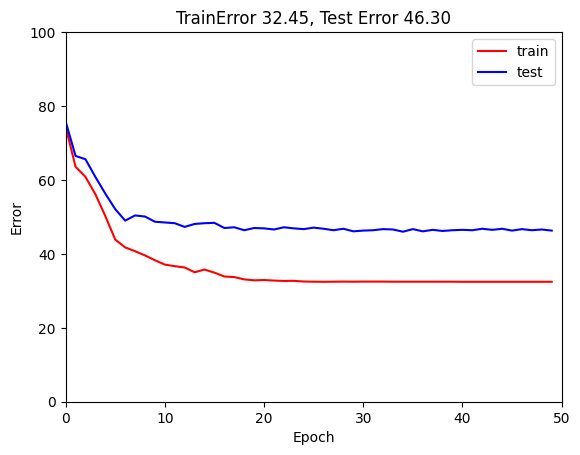

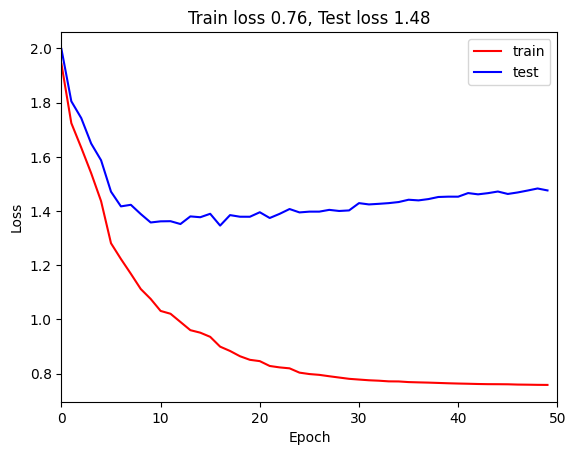

In [20]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title(r'Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

In [17]:
x_train[0]

tensor([-0.3320, -0.4719, -0.7787, -1.0097, -0.8824,  0.1039,  1.6433,  1.6525,
         0.6831, -0.3426, -1.5214, -1.1040, -0.0171,  1.0147,  0.6236, -0.0239,
         0.2541,  0.8674,  0.9354,  1.0359,  1.5935,  1.2368,  0.4102, -0.2198,
         0.0981,  0.5302,  0.5203,  0.1900,  0.0704,  0.3243,  0.2686, -0.5791,
        -1.0935, -0.8646, -0.1135,  0.0195, -0.3282, -0.7167, -0.9620, -0.8902])

In [18]:
model(x_train[0])

tensor([0.0000, 4.9939, 9.5700, 0.0000, 2.2546, 6.5844, 0.0000, 1.6562, 0.0000,
        4.4077], grad_fn=<ReluBackward0>)